# Comparison of yolo version 7,8,9,11,12 on the TACO-1 dataset

**Cloning the TACO repository**

In [161]:
# Retrieve the TACO dataset for object detection
!git clone https://github.com/pedropro/TACO



fatal: destination path 'TACO' already exists and is not an empty directory.


**Installing TACO dependencies**

In [162]:

!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu128
!pip3 install ultralytics 
!pip3 install scikit-learn
!pip3 install -r TACO/requirements.txt



Looking in indexes: https://download.pytorch.org/whl/cu128


**Downloading TACO dataset**

In [163]:
!python3 TACO/download.py --dataset_path=./TACO/data/annotations.json    

Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Loading: [..............................] - 0/1500
Loading: [..............................] - 1/1500
Loading: [..............................] - 2/1500
Loading: [..............................] - 3/1500
Loading: [..............................] - 4/1500
Loading: [..............................] - 5/1500
Loading: [..............................] - 6/1500
Loading: [..............................] - 7/1500
Loading: [..............................] - 8/1500
Loading: [..............................] - 9/1500
Loading: [..............................] - 10/1500
Loading: [..............................] - 11/1500
Loading: [..............................] - 12/1500
Loading: [..............................] - 13/1500
Loading: [..............................] - 14/1500
Loading: [..............................] - 15/1500
Loading: [..............................] - 16/1500
Loading: [................

**Create TACO-1 dataset using 70/10/20 split ratio**

In [164]:
import os
import json
import random
import shutil
from collections import defaultdict

# Constants for dataset configuration
VAL_RATIO = 0.1
TEST_RATIO = 0.2
TRAIN_RATIO = 1 - VAL_RATIO - TEST_RATIO

DATASET_SPLITS = ['train', 'valid', 'test']
SUBDIRECTORIES = ['images', 'labels']
CLASS_NAME = 'litter'
NUM_CLASSES = 1

# Path configuration
ANNOTATIONS_PATH = './TACO/data/annotations.json'
IMAGE_ROOT_DIR = './TACO/data'
OUTPUT_ROOT_DIR = './dataset'


def create_directory_structure(output_root: str) -> None:
    """Create required directory structure for YOLO dataset"""
    for split in DATASET_SPLITS:
        for subdir in SUBDIRECTORIES:
            dir_path = os.path.join(output_root, split, subdir)
            os.makedirs(dir_path, exist_ok=True)


def load_annotation_data(file_path: str) -> tuple:
    """Load COCO annotation data from JSON file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['images'], data['annotations'], data['categories'], data['info']


def group_annotations_by_image(annotations: list) -> dict:
    """Group annotations by their corresponding image ID"""
    image_annotations_map = defaultdict(list)
    for ann in annotations:
        image_annotations_map[ann['image_id']].append(ann)
    return image_annotations_map


def split_dataset(image_ids: list, seed: int = 1) -> dict:
    """Split image IDs into train, validation, and test sets using random shuffle"""
    random.seed(seed)
    ids = image_ids.copy()
    random.shuffle(ids)
    total = len(ids)
    n_train = int(TRAIN_RATIO * total)
    n_val = int(VAL_RATIO * total)
    train_ids = ids[:n_train]
    valid_ids = ids[n_train:n_train + n_val]
    test_ids = ids[n_train + n_val:]
    return {
        'train': train_ids,
        'valid': valid_ids,
        'test': test_ids
    }


def convert_bbox_to_yolo(bbox: list, image_width: int, image_height: int) -> list:
    """Convert COCO bbox format (x,y,w,h) to YOLO format (x_center,y_center,width,height normalized)"""
    x, y, width, height = bbox
    x_center = x + width / 2
    y_center = y + height / 2
    return [
        x_center / image_width,
        y_center / image_height,
        width / image_width,
        height / image_height
    ]


def process_image(image_id: int, image_metadata: dict, annotations: list, 
                 output_root: str, split: str, output_index: int) -> None:
    """Process single image: copy file and create label file"""
    # Generate sequential filename
    new_filename = f"{output_index:06d}.jpg"
    
    # Copy original image
    source_path = os.path.join(IMAGE_ROOT_DIR, image_metadata['file_name'])
    dest_path = os.path.join(output_root, split, 'images', new_filename)
    
    if not os.path.exists(dest_path):
        try:
            shutil.copy(source_path, dest_path)
        except Exception as e:
            print(f"Error copying {source_path}: {e}")
            return
    
    # Prepare label data
    label_lines = []
    img_width = image_metadata['width']
    img_height = image_metadata['height']
    
    for ann in annotations:
        yolo_bbox = convert_bbox_to_yolo(ann['bbox'], img_width, img_height)
        bbox_str = ' '.join(f'{coord:.6f}' for coord in yolo_bbox)
        label_lines.append(f"0 {bbox_str}")  # All classes mapped to 0
    
    # Write label file
    label_path = os.path.join(output_root, split, 'labels', new_filename.replace('.jpg', '.txt'))
    with open(label_path, 'w') as f:
        f.write('\n'.join(label_lines))


def process_dataset_split(split: str, image_ids: list, image_metadata_map: dict, 
                         image_annotations_map: dict, output_root: str, start_idx: int) -> int:
    """Process entire dataset split (train/valid/test)"""
    processed_count = 0
    for i, img_id in enumerate(image_ids):
        image_metadata = image_metadata_map[img_id]
        annotations = image_annotations_map.get(img_id, [])
        
        process_image(
            image_id=img_id,
            image_metadata=image_metadata,
            annotations=annotations,
            output_root=output_root,
            split=split,
            output_index=start_idx + i
        )
        processed_count += 1
    
    return processed_count


def create_dataset_yaml(output_root: str, info: dict) -> None:
    """Create YOLO dataset configuration file with extra info"""
    yaml_content = f"""# Dataset info:
# year: {info.get('year')}
# version: {info.get('version')}
# description: {info.get('description')}
# contributor: {info.get('contributor')}
# url: {info.get('url')}
# date_created: {info.get('date_created')}

train: ./train/images
val: ./valid/images
test: ./test/images

nc: {NUM_CLASSES}
names: ['{CLASS_NAME}']
title: TACO-1
"""
    config_path = os.path.join(output_root, 'dataset.yaml')
    with open(config_path, 'w') as f:
        f.write(yaml_content)



def create_taco1_dataset():
    # Setup directory structure
    create_directory_structure(OUTPUT_ROOT_DIR)

    # Load and organize data
    images, annotations, _, info = load_annotation_data(ANNOTATIONS_PATH)
    image_metadata_map = {img['id']: img for img in images}
    image_annotations_map = group_annotations_by_image(annotations)

    # Split dataset
    split_ids_local = split_dataset(list(image_metadata_map.keys()), seed=1)

    # Process each split
    current_index = 0
    for split_name in DATASET_SPLITS:
        count = process_dataset_split(
            split=split_name,
            image_ids=split_ids_local[split_name],
            image_metadata_map=image_metadata_map,
            image_annotations_map=image_annotations_map,
            output_root=OUTPUT_ROOT_DIR,
            start_idx=current_index
        )
        current_index += count

    # Create YAML configuration
    create_dataset_yaml(OUTPUT_ROOT_DIR, info)
    print("YOLO dataset conversion complete. Output directory:", OUTPUT_ROOT_DIR)

if not os.path.exists(os.path.join(OUTPUT_ROOT_DIR, 'dataset.yaml')):
    create_taco1_dataset()
else:
    print("Dataset already exists at", os.path.join(OUTPUT_ROOT_DIR, 'dataset.yaml'))



Dataset already exists at ./dataset\dataset.yaml


# Download yolo models

In [165]:
from ultralytics import YOLO
import os

MODELS_DIR = "models"

# Define models with their weights and input sizes
PAPER_MODELS = {
    "yolov5n": {"weight": "yolov5n.pt", "size": 640},
    "yolov5s": {"weight": "yolov5s.pt", "size": 640},
    "yolov5n6u": {"weight": "yolov5nu.pt", "size": 1280},  # 1280px nano
    "yolov5s6u": {"weight": "yolov5su.pt", "size": 1280},  # 1280px small
    "yolov8n": {"weight": "yolov8n.pt", "size": 640},
    "yolov8s": {"weight": "yolov8s.pt", "size": 640}
}

# Newer YOLO versions for comparison
NEW_MODELS = {
    "yolov9t": {"weight": "yolov9t.pt", "size": 640},
    "yolov9s": {"weight": "yolov9s.pt", "size": 640},
    "yolov10n": {"weight": "yolov10n.pt", "size": 640},
    "yolov10s": {"weight": "yolov10s.pt", "size": 640},
    "yolo11n": {"weight": "yolo11n.pt", "size": 640},
    "yolo11s": {"weight": "yolo11s.pt", "size": 640},
    "yolo12n": {"weight": "yolo12n.pt", "size": 640},
    "yolo12s": {"weight": "yolo12s.pt", "size": 640}
}

# Combine all models
ALL_MODELS = {**PAPER_MODELS, **NEW_MODELS}

# Create model folder
os.makedirs(MODELS_DIR, exist_ok=True)

# Download all model weights if not already present
for name, params in ALL_MODELS.items():
    weight = params["weight"]
    model_path = f"{MODELS_DIR}/{weight}"
    if not os.path.exists(model_path):
        model = YOLO(weight)
        model.save(model_path)
        if os.path.exists(weight):
            os.remove(weight)
        print(f"✅ Downloaded {name} => {model_path}")
    else:
        print(f"✅ Already exists: {model_path}")


✅ Already exists: models/yolov5n.pt
✅ Already exists: models/yolov5s.pt
✅ Already exists: models/yolov5nu.pt
✅ Already exists: models/yolov5su.pt
✅ Already exists: models/yolov8n.pt
✅ Already exists: models/yolov8s.pt
✅ Already exists: models/yolov9t.pt
✅ Already exists: models/yolov9s.pt
✅ Already exists: models/yolov10n.pt
✅ Already exists: models/yolov10s.pt
✅ Already exists: models/yolo11n.pt
✅ Already exists: models/yolo11s.pt
✅ Already exists: models/yolo12n.pt
✅ Already exists: models/yolo12s.pt


**Check for GPU support**

In [166]:
import ultralytics
ultralytics.checks()



Ultralytics 8.3.151  Python-3.12.7 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Setup complete  (16 CPUs, 15.8 GB RAM, 555.1/952.3 GB disk)


**Train the yolo models**

In [167]:
import os
import pandas as pd
from tqdm import tqdm

# =====================
# CONSTANTS 
# =====================

#Parameters
TRAINING_EPOCHS = 100
OPTIMIZER = 'auto'  # Automatic optimizer selection (if supported)
AUG_FLIPUD = 0.5      # Vertical flip probability
AUG_DEGREES = 10      # Rotation range: -10 to +10 degrees
CONF_VALUES = [00.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95] #Confidence tuning thresholds

#Dirs
DATASET_PATH = "dataset/dataset.yaml"  # Updated dataset path
MODELS_DIR = "models"
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

PROGRESS_CSV = os.path.join(RESULTS_DIR, "progress.csv")

# =====================
# TRAINING FUNCTION
# =====================
def train_model(model_name, params):
    """Train a YOLO model with specified parameters"""
    print(f"Training {model_name}")
    
    # Load pretrained model
    model = YOLO(os.path.join(MODELS_DIR, params['weight']))
    
    # Paper-specific augmentations
    augmentations = {
        'flipud': AUG_FLIPUD,
        'degrees': AUG_DEGREES,
    }
    
    # Training parameters
    train_args = {
        'data': DATASET_PATH,
        'epochs': TRAINING_EPOCHS, 
        'imgsz': params['size'],
        'batch': -1,  
        'optimizer': OPTIMIZER,  
        'augment': True,
        'name': f"{model_name}_train",
        'save': True,
        'exist_ok': True,
        **augmentations
    }
    
    # Special handling for 1280px models
    if "6u" in model_name:
        train_args['rect'] = True  # Use rectangular training
    
    # Start training
    results = model.train(**train_args)
    
    return model, results

# =====================
# CONFIDENCE TUNING
# =====================
def tune_confidence(model, model_name):
    """Optimize confidence threshold as per paper methodology"""
    best_map50 = 0
    best_conf = CONF_VALUES[0]
    metrics_list = []

    print(f"\nTuning confidence for {model_name}")
    for conf in tqdm(CONF_VALUES, desc="Testing confidence thresholds"):
        metrics = model.val(data=DATASET_PATH, conf=conf, split='val')
        metrics_list.append({'conf': conf, 'map50': metrics.box.map50})
        if metrics.box.map50 > best_map50:
            best_map50 = metrics.box.map50
            best_conf = conf

    print(f"Best confidence: {best_conf:.3f} (mAP50: {best_map50:.4f})")
    return best_conf, metrics_list

# =====================
# EVALUATION FUNCTION
# =====================
def evaluate_model(model, model_name, conf_threshold):
    """Evaluate model on test set with tuned confidence"""
    metrics = model.val(
        data=DATASET_PATH,
        conf=conf_threshold,
        split='test',
        name=f"{model_name}_test"
    )
    
    # Get model size
    ckpt_path = model.ckpt_path if hasattr(model, 'ckpt_path') else model.predictor.model.ckpt_path
    size_mb = os.path.getsize(ckpt_path) / (1024 * 1024)
    
    return {
        'model': model_name,
        'size_mb': size_mb,
        'conf_threshold': conf_threshold,
        'map50': metrics.box.map50,
        'map50_95': metrics.box.map
    }

# =====================
# TRAINING PIPELINE 
# =====================
def train_all_models():
    # Load progress if exists
    if os.path.exists(PROGRESS_CSV):
        progress_df = pd.read_csv(PROGRESS_CSV)
        completed_models = set(progress_df['model'])
        results = progress_df.to_dict('records')
        print(f"Resuming. Already completed: {completed_models}")
    else:
        completed_models = set()
        results = []

    for model_name, params in ALL_MODELS.items():
        if model_name in completed_models:
            print(f"Skipping {model_name}, already completed.")
            continue
        try:
            model, train_results = train_model(model_name, params)
            best_conf, conf_metrics = tune_confidence(model, model_name)
            metrics = evaluate_model(model, model_name, best_conf)
            metrics['conf_tuning_metrics'] = conf_metrics  # Store all map50 values
            results.append(metrics)
            pd.DataFrame(results).to_csv(PROGRESS_CSV, index=False)
        except Exception as e:
            print(f"\n❌ Error training {model_name}: {str(e)}")
            continue
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(RESULTS_DIR, "final_results.csv"), index=False)
    return results_df

#train the models
results_df = train_all_models()


Resuming. Already completed: {'yolov10s', 'yolo12n', 'yolov5s', 'yolo11n', 'yolov8n', 'yolov8s', 'yolov10n', 'yolov5s6u', 'yolov5n', 'yolo11s', 'yolo12s', 'yolov9t', 'yolov9s', 'yolov5n6u'}
Skipping yolov5n, already completed.
Skipping yolov5s, already completed.
Skipping yolov5n6u, already completed.
Skipping yolov5s6u, already completed.
Skipping yolov8n, already completed.
Skipping yolov8s, already completed.
Skipping yolov9t, already completed.
Skipping yolov9s, already completed.
Skipping yolov10n, already completed.
Skipping yolov10s, already completed.
Skipping yolo11n, already completed.
Skipping yolo11s, already completed.
Skipping yolo12n, already completed.
Skipping yolo12s, already completed.


**Printing results**

In [168]:
# import numpy as np
# import matplotlib.pyplot as plt

# def print_results(results_df):
#     print("\n\033[1mTraining Complete! Results:\033[0m")
#     print(results_df)

#     # Plot mAP50 vs Model Size
#     plt.figure(figsize=(12, 7))
#     x = results_df['map50']
#     y = results_df['size_mb']
#     labels = results_df['model']

#     plt.scatter(x, y, s=120, alpha=0.7)

#     # Offset labels to avoid overlap
#     for i, label in enumerate(labels):
#         # Alternate label positions for better separation
#         dx = 0.002 if i % 2 == 0 else -0.002
#         dy = 0.1 if i % 3 == 0 else -0.1
#         plt.annotate(label, (x.iloc[i] + dx, y.iloc[i] + dy), fontsize=10, alpha=0.9)

#     plt.title('mAP50 vs Model Size (TACO Dataset)', fontsize=15)
#     plt.xlabel('mAP50', fontsize=13)
#     plt.ylabel('Model Size (MB)', fontsize=13)
#     plt.yscale('log')
#     plt.grid(True, linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.savefig(os.path.join(RESULTS_DIR, "map50_vs_size.png"), dpi=300)
#     plt.show()

#     # Comparison table
#     paper_results = results_df[results_df['model'].isin(PAPER_MODELS.keys())]
#     new_results = results_df[results_df['model'].isin(NEW_MODELS.keys())]
#     print("\n\033[1mPaper Models vs New Models:\033[0m")
#     print(pd.concat([paper_results, new_results]).sort_values('map50', ascending=False))

# print_results(results_df)


## Results

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import seaborn as sns

# Let's load the annotations from the TACO dataset.

with open(ANNOTATIONS_PATH, "r") as f:
	taco_json = json.load(f)

# Convert to DataFrame for easier handling
images_df = pd.DataFrame(taco_json["images"])
annotations_df = pd.DataFrame(taco_json["annotations"])

# # Merge image file names into annotations
annotations = annotations_df.merge(images_df[["id", "file_name", "width", "height"]], left_on="image_id", right_on="id")
image_paths = annotations["file_name"].unique()


**Figure 2: Bounding Box Size Distribution**

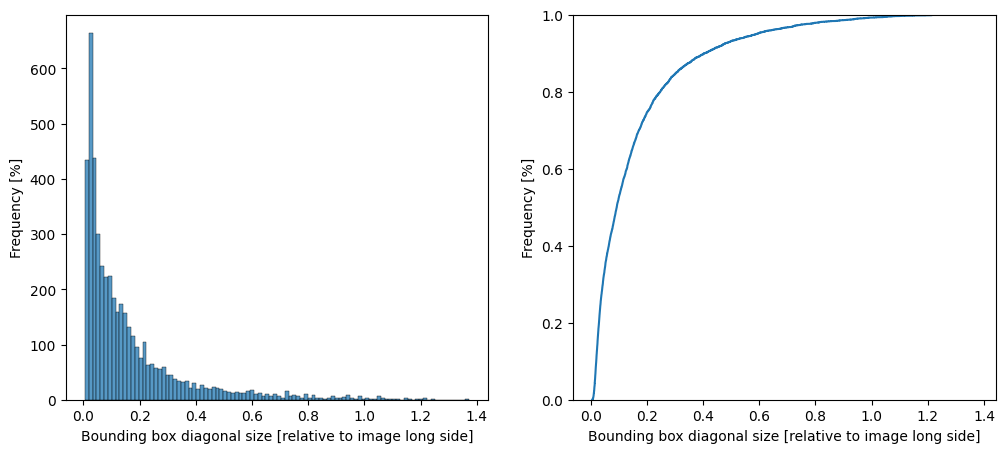

In [171]:
def plot_bbox_distribution(annotations_df):
    # Extract bbox width and height from the bbox column
    bbox_array = np.stack(annotations_df['bbox'].apply(lambda b: np.array(b)))
    bbox_w = bbox_array[:, 2]
    bbox_h = bbox_array[:, 3]
    img_w = annotations_df['width'].values
    img_h = annotations_df['height'].values

    # Calculate normalized diagonal
    diagonal_norm = np.sqrt((bbox_w / img_w) ** 2 + (bbox_h / img_h) ** 2)

    # Plot histogram
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.histplot(diagonal_norm, bins=100)
    plt.xlabel("Bounding box diagonal size [relative to image long side]")
    plt.ylabel("Frequency [%]")


    # Plot CDF
    plt.subplot(122)
    sns.ecdfplot(diagonal_norm)
    plt.xlabel("Bounding box diagonal size [relative to image long side]")
    plt.ylabel("Frequency [%]")
    plt.savefig("bbox_size_distribution.png", dpi=300)

plot_bbox_distribution(annotations)

**Figure 3: mAP50 vs Model Size (Pareto Plot)**

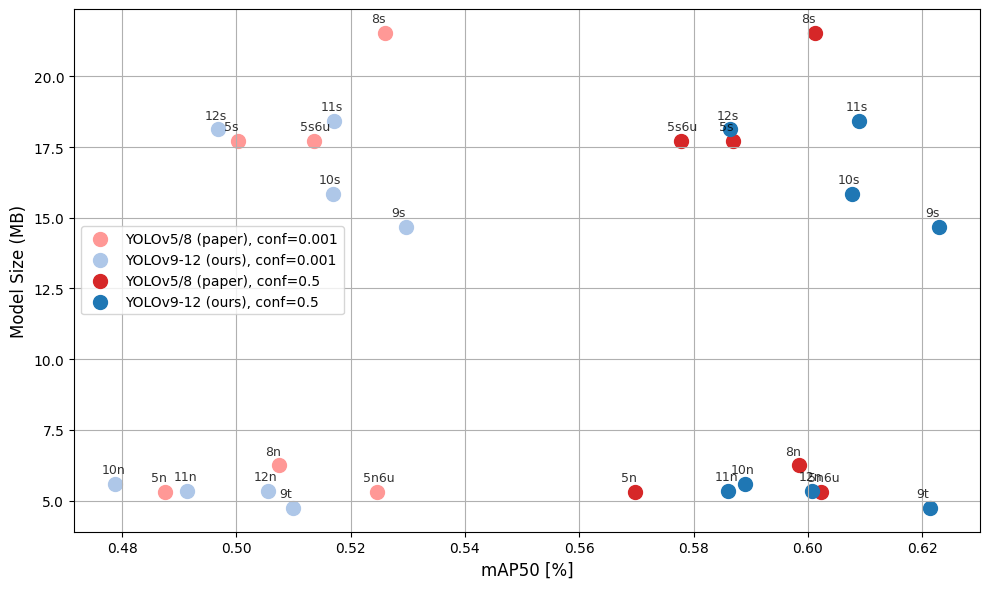

In [ ]:
import ast

def prepare_performance_data(final_results):
    """
    Prepare a DataFrame for performance comparison plots.
    Returns columns: model, model_size_mb, conf, mAP50
    """
    # Extract mAP50 at conf=0.001 and conf=0.5 for each model
    rows = []
    for row in final_results.itertuples():
        conf_metrics = ast.literal_eval(row.conf_tuning_metrics)
        conf_map = {m["conf"]: m["map50"] for m in conf_metrics}
        for conf in [0.001, 0.5]:
            map50 = conf_map.get(conf)
            rows.append({
                "model": row.model,
                "size_mb": row.size_mb,
                "conf_threshold": conf,
                "map50": map50,
                "map50_95": row.map50_95
            })
    plot_df = pd.DataFrame(rows)
    return plot_df

def plot_performance_comparison(results_df):
    # Define model groups and colors
    paper_models = ["yolov5n", "yolov5s", "yolov5n6u", "yolov5s6u", "yolov8n", "yolov8s"]
    new_models = ["yolov9t", "yolov9s", "yolov10n", "yolov10s", "yolo11n", "yolo11s", "yolo12n", "yolo12s"]

    color_map = {
        (False, 0.5): "#1f77b4",  # Paper models, conf=0.001 (blue)
        (False, 0.001): "#aec7e8",    # Paper models, conf=0.5 (light blue)
        (True, 0.5): "#d62728",   # New models, conf=0.001 (red)
        (True, 0.001): "#ff9896",     # New models, conf=0.5 (light red)
    }

    plt.figure(figsize=(10, 6))
    for conf in [0.001, 0.5]:
        for is_paper in [True, False]:
            if is_paper:
                models = paper_models
                label = f"YOLOv5/8 (paper), conf={conf}"
            else:
                models = new_models
                label = f"YOLOv9-12 (ours), conf={conf}"
            df_group = results_df[(results_df["model"].isin(models)) & (results_df["conf_threshold"] == conf)]
            if not df_group.empty:
                plt.scatter(
                    df_group["map50"],
                    df_group["size_mb"],
                    label=label,
                    s=100,
                    color=color_map[(is_paper, conf)]
                )
                # Add labels for each point, all at right top
                for _, row in df_group.iterrows():
                    model_label = row["model"]
                    if model_label.startswith("yolov"):
                        model_label = model_label.replace("yolov", "")
                    elif model_label.startswith("yolo"):
                        model_label = model_label.replace("yolo", "")
                    plt.annotate(
                        model_label,
                        (row["map50"], row["size_mb"]),
                        xytext=(-10, 15),
                        textcoords='offset points',
                        fontsize=9,
                        ha='left',
                        va='top',
                        alpha=0.8
                    )
    plt.ylabel("Model Size (MB)", fontsize=12)
    plt.xlabel("mAP50 [%]", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("model_comparison.png", dpi=300)

# Load the final results CSV
final_results = pd.read_csv(os.path.join(RESULTS_DIR, "final_results.csv"))
performance_data = prepare_performance_data(final_results)
plot_performance_comparison(performance_data)

**Table I: Quantitative Results**

In [182]:
from IPython.display import display

def make_table1(performance_data):
    def format_bold(val, best):
        """Return bold string if val is the best, else plain string."""
        return f"**{val:.1f}**" if val == best else f"{val:.1f}"

    # Model order for sorting
    model_order = [
        "yolov5n", "yolov5s", "yolov5n6u", "yolov5s6u", "yolov8n", "yolov8s",
        "yolov9t", "yolov9s", "yolov10n", "yolov10s", "yolo11n", "yolo11s", "yolo12n", "yolo12s"
    ]

    # Find best mAP50 and mAP50-95 for tuned confidence
    best_map50 = performance_data[performance_data["conf_threshold"] == 0.5]["map50"].max()
    best_map50_95 = performance_data[performance_data["conf_threshold"] == 0.5]["map50_95"].max()

    # Build table rows for YOLO models (this paper)
    table_rows = []
    for model in model_order:
        df_def = performance_data[(performance_data["model"] == model) & (performance_data["conf_threshold"] == 0.001)]
        df_tuned = performance_data[(performance_data["model"] == model) & (performance_data["conf_threshold"] == 0.5)]
        if df_def.empty or df_tuned.empty:
            continue
        row = {}
        row["Method"] = model.replace("yolov", "YOLO-v").replace("yolo", "YOLO-")
        row["Dataset"] = "TACO"
        row["Default mAP50"] = df_def["map50"].values[0] * 100
        row["Default mAP50-95"] = df_def["map50_95"].values[0] * 100
        row["Tuned mAP50"] = df_tuned["map50"].values[0] * 100
        row["Tuned mAP50-95"] = df_tuned["map50_95"].values[0] * 100
        row["Improvement mAP50"] = row["Tuned mAP50"] - row["Default mAP50"]
        row["Improvement mAP50-95"] = row["Tuned mAP50-95"] - row["Default mAP50-95"]
        row["Size (MB)"] = df_tuned["size_mb"].values[0]
        table_rows.append(row)

    # Convert to DataFrame and keep order
    table1_df = pd.DataFrame(table_rows)
    # Format for display (bold best results)
    table1_df["Tuned mAP50"] = table1_df["Tuned mAP50"].apply(lambda x: format_bold(x, best_map50*100))
    table1_df["Tuned mAP50-95"] = table1_df["Tuned mAP50-95"].apply(lambda x: format_bold(x, best_map50_95*100))

    table1_df = table1_df[[
        "Method", "Dataset", "Default mAP50", "Default mAP50-95",
        "Tuned mAP50", "Tuned mAP50-95", "Improvement mAP50", "Improvement mAP50-95", "Size (MB)"
    ]]
    table1_df.reset_index(drop=True, inplace=True)
    return table1_df

# Usage:
table1_df = make_table1(performance_data)
display(table1_df)

,Method,Dataset,Default mAP50,Default mAP50-95,Tuned mAP50,Tuned mAP50-95,Improvement mAP50,Improvement mAP50-95,Size (MB)
0,YOLO-v5n,TACO,48.746105,48.468031,57.0,48.5,8.234024,0.0,5.303351
1,YOLO-v5s,TACO,50.024517,45.429401,58.7,45.4,8.662242,0.0,17.718757
2,YOLO-v5n6u,TACO,52.461561,40.484289,60.2,40.5,7.775585,0.0,5.303351
3,YOLO-v5s6u,TACO,51.353071,42.825591,57.8,42.8,6.419629,0.0,17.718757
4,YOLO-v8n,TACO,50.754182,49.067595,59.9,49.1,9.099530,0.0,6.244724
5,YOLO-v8s,TACO,52.600015,50.182684,60.1,**50.2**,7.533207,0.0,21.540684
6,YOLO-v9t,TACO,50.997580,44.280893,62.1,44.3,11.145485,0.0,4.737559
7,YOLO-v9s,TACO,52.960342,44.342685,**62.3**,44.3,9.331466,0.0,14.674327
8,YOLO-v10n,TACO,47.880714,45.272867,58.9,45.3,11.014775,0.0,5.586822
9,YOLO-v10s,TACO,51.690823,47.666096,60.8,47.7,9.075445,0.0,15.850959
